# Importation

In [1]:
import cv2
import numpy as np
import os
import time
import warnings
from sklearn.metrics.pairwise import cosine_similarity
import sys
import re
from nltk import download
import pandas as pd
from tqdm import tqdm
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk import pos_tag, RegexpParser, word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install pyLDAvis
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


# Download NLTK resources
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')

from PyPDF2 import PdfReader
from PIL import ImageGrab, Image
import fitz
import pytesseract
from pdf2image import convert_from_path
import pyautogui

# This Python environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here are several helpful packages to load in
import easyocr
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g., pd.read_csv)
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB


NameError: name 'nltk' is not defined

In [ ]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\hamma\AppData\Local\Tesseract-OCR\tesseract.exe'

# Transforming to pictures

In [ ]:
# PDF file paths
pdfPMBOK = "PMBOK6-2017.pdf" #431-494
pdfPMI = "practice-standard-project-risk-management.pdf" #1-116
output_folder_1="PMBOOKimgs"
output_folder_2="Practiceimgs"

In [42]:
def convert_pdf_to_images(pdf_file_path, output_folder, start_page, end_page):
    images = convert_from_path(pdf_file_path, output_folder=output_folder, fmt='png', first_page=start_page, last_page=end_page, output_file="page")

    print("Done.")

In [43]:
convert_pdf_to_images(pdfPMBOK, output_folder_1, 431, 494)

Done.


In [44]:
convert_pdf_to_images(pdfPMI, output_folder_2, 1, 116)

Done.


# Extracting Figures

### YOLO: (does not work)

###### must install yolov3.weights yolov3.cfg coco.names (ask chatgpt)

### openCV:

In [26]:
def detect_shapes(image_path, min_contour_area=1000):
    # Read the image
    image = cv2.imread("PMBOOKimgs/"+image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    k=0
    for contour in contours:
        k=k+1
        # Calculate the contour area
        area = cv2.contourArea(contour)

        # If the contour area is greater than the minimum threshold
        if area >= min_contour_area:
            # Approximate the contour as a polygon
            epsilon = 0.04 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Check if the polygon has 4 vertices, indicating a rectangle
            if len(approx) == 4:
                # Get the bounding box coordinates of the rectangle
                x, y, w, h = cv2.boundingRect(contour)

                # Define a region of interest (ROI) using the rectangle coordinates
                roi = image[y:y+h, x:x+w]

                # Save the ROI as an image for inspection
                cv2.imwrite("screenshots/"+image_path+"/"+str(k)+"detected__"+image_path, roi)                
                

In [123]:
detect_shapes("page0001-445.png")

In [124]:
for k in os.listdir("PMBOOKimgs/"):
    os.makedirs("screenshots/"+k, exist_ok=True)
    detect_shapes(k)

# Extracting Texts from images

### Using Pytesseract from imgs:

In [41]:
def extract_text(image_path):
    # Read the image
    image = cv2.imread(image_path)
    

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Use adaptive thresholding to segment text from the background
    _, threshold = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Remove horizontal and vertical lines using morphological operations
    kernel = np.ones((4, 4), np.uint8)
    clean_image = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel)
    text = pytesseract.image_to_string(Image.fromarray(threshold))


    print(text)
    # Save the extracted text to a file
    #with open(output_text_path, 'w', encoding='utf-8') as text_file:
        #text_file.write(text)

In [44]:
extract_text("screenshots/page0001-446.png/54detected__page0001-446.png")

Project
Management
Plan

Project management plan

« Requirements management plan
« Schedule management plan
« Cost management plan

« Resource management plan
* Quality management plan
« Risk management plan
« Scope baseline

* Schedule baseline

* Cost baseline

Project
Documents

reject documents
Assumption log
Cost estimates 11.2

Issue log Risks
Lessons learned register

Project
eceeeseserseseeseneces: Docurnents

Risk register
* Risk report

Requirements documentation
Resource requirements.
Stakeholder register

Pr
.
.
* Duration estimates Identify
.
.
.
.
.

12.1
Plan
Procurement
Management

Procurement documentation

12.2
Conduct
Procurements

Agreements

Enterprise/
Organization

Enterprise environmental factors.
Organizational process assets

Project documents updates
« Assumption log

* Issue log

« Lessons learned register




###### either extracts everything or extract without figures but wrong

# Extracting Texts from pdf

#### Fitz

##### extracting titles 

In [558]:
import fitz  # PyMuPDF
import re
import torch
from transformers import BertTokenizer, BertForMaskedLM

# Charger le modèle BERT
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

def extract_titles_and_descriptions_from_pdf(pdf_file):
    pdf_document = fitz.open(pdf_file)
    titles_with_descriptions = []

    for page_num in range(len(pdf_document)):
        page = pdf_document[page_num]
        page_text = page.get_text()
        page_text=page_text.replace('—','\n')

        # Utilisez une expression régulière pour rechercher des motifs de titre "11.x" ou "11.x.x" ou "11.x.x.x"
        matches = re.findall(r'(11+(\.\d+)+)\s+(.+)', page_text)
        for match in matches:
            title = match[0]
            description = match[2]

            # Prédire la partie manquante de la description en utilisant BERT
            masked_text = f"[MASK] {description}"
            input_ids = tokenizer.encode(masked_text, add_special_tokens=True, return_tensors="pt")
            mask_index = input_ids[0].tolist().index(tokenizer.mask_token_id)

            with torch.no_grad():
                predictions = model(input_ids)
            predicted_token_id = torch.argmax(predictions.logits[0, mask_index]).item()
            predicted_word = tokenizer.decode(predicted_token_id)

            # Remplacez le masque par le mot prédit dans la description
            description = description.replace("[MASK]", predicted_word)

            # Ajoutez le titre et la description complète à la liste
            titles_with_descriptions.append(f"{title} {description}")

    pdf_document.close()
    return titles_with_descriptions

# Exemple d'utilisation
pdf_file_path = 'PMBOK6-2017.pdf'
titles_with_descriptions = extract_titles_and_descriptions_from_pdf(pdf_file_path)

# Imprimez les titres avec les descriptions complètes
for title_with_description in titles_with_descriptions:
    print(title_with_description)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


11.1 Plan Risk Management ..............................................................................................401
11.1.1 Plan Risk Management: Inputs ......................................................................402
11.1.2 Plan Risk Management: Tools and Techniques .............................................404
11.1.3 Plan Risk Management: Outputs ...................................................................405
11.2 Identify Risks ..............................................................................................................409
11.2.1 Identify Risks: Inputs .....................................................................................411
11.2.2 Identify Risks: Tools and Techniques ............................................................414
11.2.3 Identify Risks: Outputs ...................................................................................417
11.3 Perform Qualitative Risk Analysis .........................................

##### extracting Texts 

In [559]:
import fitz  # PyMuPDF
import re
import pandas as pd  # Import Pandas
import torch
from transformers import BertTokenizer, BertForMaskedLM

# Charger le modèle BERT
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

def extract_concepts_and_definitions_from_pdf(pdf_file):
    pdf_document = fitz.open(pdf_file)
    concepts_and_definitions = []
    current_concept = ""
    current_definition = ""

    for page_num in range(len(pdf_document)):
        page = pdf_document[page_num]
        page_text = page.get_text()
        page_text = page_text.replace('—', '\n')

        # Split the page text into lines
        lines = page_text.split("\n")

        for line in lines:
            # Check if the line matches the pattern for a concept
            if re.match(r'(11+(\.\d+)+)\s+(.+)', line):
                if current_concept:
                    # Append the current concept and definition to the list as a tuple
                    concepts_and_definitions.append((current_concept, current_concept_name, current_definition))
                
                # Split the line into concept and definition
                concept_match = re.match(r'(11+(\.\d+)+)\s+(.+)', line)
                current_concept = concept_match.group(1)
                current_concept_name = concept_match.group(3)
                current_definition = ""
            else:
                # If the line does not match the pattern, consider it part of the definition
                current_definition += "\n" + line

    # Append the last concept and definition to the list
    concepts_and_definitions.append((current_concept, current_concept_name, current_definition))
    pdf_document.close()

    # Create a DataFrame
    df = pd.DataFrame(concepts_and_definitions, columns=["Number", "Concept", "Definition"])
    return df

# Example of usage
pdf_file_path = 'PMBOK6-2017.pdf'
df = extract_concepts_and_definitions_from_pdf(pdf_file_path)

# Print or process the DataFrame
df

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,Number,Concept,Definition
0,11.1,Plan Risk Management ............................,
1,11.1.1,Plan Risk Management: Inputs ....................,
2,11.1.2,Plan Risk Management: Tools and Techniques ......,
3,11.1.3,Plan Risk Management: Outputs ...................,"\n\nNot For Distribution, Sale or Reproduction..."
4,11.2,Identify Risks ..................................,
...,...,...,...
154,11.7.3.1,WORK PERFORMANCE INFORMATION,\nDescribed in Section 4.5.1.3. Work performan...
155,11.7.3.2,CHANGE REQUESTS,\nDescribed in Section 4.3.3.4. The Monitor Ri...
156,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nAny change to the project management plan go...
157,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nProject documents that may be updated as a r...


##### =>>>>>>>>bad result

In [555]:
import fitz
import pandas as pd

def extract_plain_text_from_pdf(pdf_file_path):
    # Open the PDF file
    pdf_document = fitz.open(pdf_file_path)

    # Initialize an empty list to store the extracted data
    data = []

    for page_number in range(431, 495):
        page = pdf_document.load_page(page_number)
        text = page.get_text()
        blocks = text.split("\n")

        # Initialize variables to store the current title and description
        current_title = ""
        current_description = ""

        for block in blocks:
            block = block.strip()

            if "Figure" in block:
                continue
            elif block.isupper():
                # If a new title is found, add the previous title and description to the data list
                if current_title:
                    data.append({"title": current_title, "description": current_description})
                current_title = block
                current_description = ""
            elif block.istitle():
                # If a new title is found, add the previous title and description to the data list
                if current_title:
                    data.append({"title": current_title, "description": current_description})
                current_title = block
                current_description = ""
            elif block.startswith("- "):
                continue
            else:
                # Append the block to the current description
                current_description += block + "\n"

        # Add the last title and description to the data list
        if current_title:
            data.append({"title": current_title, "description": current_description})

    # Close the PDF document
    pdf_document.close()

    # Create a DataFrame from the extracted data
    df = pd.DataFrame(data)

    return df


In [556]:
# Extract plain text and create DataFrame
df = extract_plain_text_from_pdf(pdfPMBOK)

In [557]:
df

,title,description
0,Part 1 - Guide,
1,.1 Inputs,.1 Project charter\n.2 Project management plan...
2,.2 Tools & Techniques,.1 Expert judgment\n.2 Data analysis\n
3,.3 Meetings,
4,.3 Outputs,.1 Risk management plan\n
...,...,...
476,11.7.3.3 PROJECT MANAGEMENT PLAN UPDATES,Any change to the project management plan goes...
477,Part 1 - Guide,
478,11.7.3.4 PROJECT DOCUMENTS UPDATES,Project documents that may be updated as a res...
479,11.7.3.5 ORGANIZATIONAL PROCESS ASSETS UPDATES,Organizational process assets that are updated...


In [14]:
df.to_excel("data.xlsx", index=False)

# Returning to extracting from imgs:

#### we thought about covering figures with black screen and reading the rest using EasyOCR & cv2

# deleting figures in  image

In [11]:
def detect_and_remove_rectangles(image_path, min_contour_area=1000):
    # Read the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask with the same size as the image, initialized to white
    mask = np.ones_like(image) * 255

    for contour in contours:
        # Calculate the contour area
        area = cv2.contourArea(contour)

        # If the contour area is greater than the minimum threshold
        if area >= min_contour_area:
            # Approximate the contour as a polygon
            epsilon = 0.04 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Check if the polygon has 4 vertices, indicating a rectangle
            if len(approx) == 4:
                # Get the bounding box coordinates of the rectangle
                x, y, w, h = cv2.boundingRect(contour)

                # Set the region corresponding to the rectangle to black in the mask
                mask[y:y+h, x:x+w] = 0

    # Use the mask to copy the non-rectangle parts of the image to a new image
    result = cv2.bitwise_and(image, mask)

    return result


# Get a list of all image files in the folder
image_files = [f for f in os.listdir(output_folder_1) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Specify the output folder
output_folder = "output_folder_PMBOOKimgs"

# Check if the output folder exists, and if not, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each image in the folder
for image_file in image_files:
    # Construct the full path to the image file
    image_path = os.path.join(output_folder_1, image_file)

    # Call the detect_and_remove_rectangles function
    output_image = detect_and_remove_rectangles(image_path)

    # Define the output file path for each processed image
    output_file = os.path.join(output_folder, image_file)

    # Save the processed image to the output folder
    cv2.imwrite(output_file, output_image)

print("Processing completed. Processed images are saved in the '{}' folder.".format(output_folder))

Processing completed. Processed images are saved in the 'output_folder_PMBOOKimgs' folder.


# Using EasyOCR now to detect words:(DO NOT RUN)

# (DO NOT RUN)

# (DO NOT RUN)

# (DO NOT RUN)

In [13]:
# Initialize the EasyOCR reader with the desired languages
reader = easyocr.Reader(['en'])

# Specify the folder containing the images
folder_path = 'output_folder_PMBOOKimgs'

# List all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Sort the image files based on their names
image_files.sort()

# Define the image to be skipped
skip_image = 'page0001-432.png'

# Create a text file to store the OCR results
output_file = 'ocr_results_PMBOOKimgs.txt'

# Loop through each image file
with open(output_file, 'w', encoding='utf-8') as txt_file:
    for image_file in image_files:
        # Check if the current image file matches the one to be skipped
        if image_file == skip_image:
            print(f"Skipping {skip_image}")
            continue  # Skip this image and move to the next one

        # Construct the full path to the image
        image_path = os.path.join(folder_path, image_file)

        # Load the image and convert it to a NumPy array
        image = np.array(Image.open(image_path))

        # Perform OCR on the image
        results = reader.readtext(image)

        # Write the OCR results for the current image to the text file
        for (text, bounding_box, prob) in results:
            txt_file.write(f"{bounding_box}\n")

print(f"OCR results have been saved to {output_file}")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Skipping page0001-432.png
OCR results have been saved to ocr_results_PMBOOKimgs.txt


# Extracting texts from figures to text file:

# (DO NOT RUN)

# (DO NOT RUN)

In [46]:
def extract_text_from_blocks(image_folder, output_folder, zoom_factor=1.0, min_characters=5):
    # Iterate through the images in the folder
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png', '.jpeg')):  # Adjust the file extensions as needed
            # Construct the full path to the image
            image_path = os.path.join(image_folder, filename)

            # Read the image
            image = cv2.imread(image_path)

            # Convert the image to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Use adaptive thresholding to segment text from the background
            _, threshold = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

            # Find contours of the blocks
            contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Initialize a counter for generating unique filenames
            counter = 1

            for contour in contours:
                # Extract the region of interest (ROI) for each block
                x, y, w, h = cv2.boundingRect(contour)
                block_roi = image[y:y+h, x:x+w]

                # Apply the zoom factor to the block ROI
                if zoom_factor != 1.0:
                    block_roi = cv2.resize(block_roi, None, fx=zoom_factor, fy=zoom_factor)

                # Use Tesseract to extract text from the block ROI
                text = pytesseract.image_to_string(Image.fromarray(block_roi))

                # Check if the extracted text contains at least 5 characters
                if len(text.strip()) >= min_characters:
                    # Print the extracted text
                    print(text)

                    # Generate a unique filename based on the counter
                    output_file = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_{counter}.txt")

                    # Increment the counter
                    counter += 1

                    # Save the extracted text to a file
                    with open(output_file, 'w', encoding='utf-8') as text_file:
                        text_file.write(text)

# Example usage with a zoom factor of 2.0 and a minimum of 5 characters:
input_folder = 'PMBOOKimgs'
output_folder = 'output_figures'
extract_text_from_blocks(input_folder, output_folder, zoom_factor=2.0, min_characters=10)

KeyboardInterrupt: 

# now extracting data from textfile(used because easyocr is too heavy to compile each time) into a dataframe:

In [2]:
import re
import pandas as pd

def extract_concepts_and_definitions_from_text(text_file):
    with open(text_file, 'r', encoding='utf-8') as file:
        text = file.read()

    concepts_and_definitions = []
    current_concept = ""
    current_concept_name = ""
    current_definition = ""

    lines = text.split('\n')

    for line in lines:
        # Check if the line matches the pattern for a concept
        if re.match(r'(\d+(\.\d+)*)\s+(.+)', line):
            if current_concept:
                # Append the current concept and definition to the list as a tuple
                concepts_and_definitions.append((current_concept, current_concept_name, current_definition))

            # Split the line into concept and definition
            concept_match = re.match(r'(\d+(\.\d+)*)\s+(.+)', line)
            current_concept = concept_match.group(1)
            current_concept_name = concept_match.group(3)
            current_definition = ""
        else:
            # If the line does not match the pattern, consider it part of the definition
            current_definition += "\n" + line

    # Append the last concept and definition to the list
    concepts_and_definitions.append((current_concept, current_concept_name, current_definition))

    # Create a DataFrame
    df = pd.DataFrame(concepts_and_definitions, columns=["Number", "Concept", "Definition"])
    return df

# Example of usage
text_file_path = 'ocr_results_PMBOOKimgs.txt'  # Replace with the path to your text file
df = extract_concepts_and_definitions_from_text(text_file_path)

# Print or process the DataFrame
print(df)


       Number                                Concept  \
0        11.1                   Plan Risk Management   
1        11.2                         Identify Risks   
2        11.3      Perform Qualitative Risk Analysis   
3        11.4     Perform Quantitative Risk Analysis   
4        11.5                    Plan Risk Responses   
..        ...                                    ...   
113  11.7.3.1           WORK PERFORMANCE INFORMATION   
114  11.7.3.2                        CHANGE REQUESTS   
115  11.7.3.3        PROJECT MANAGEMENT PLAN UPDATES   
116  11.7.3.4              PROJECT DOCUMENTS UPDATES   
117  11.7.3.5  ORGANIZATIONAL PROCESS ASSETS UPDATES   

                                            Definition  
0    \nThe process of defining how to conduct risk ...  
1    \nThe process of identifying individual projec...  
2    \nThe process of prioritizing individual proje...  
3    \nThe process ofnumerically analyzing the comb...  
4    \nThe process of developing options, 

In [3]:
df

,Number,Concept,Definition
0,11.1,Plan Risk Management,\nThe process of defining how to conduct risk ...
1,11.2,Identify Risks,\nThe process of identifying individual projec...
2,11.3,Perform Qualitative Risk Analysis,\nThe process of prioritizing individual proje...
3,11.4,Perform Quantitative Risk Analysis,\nThe process ofnumerically analyzing the comb...
4,11.5,Plan Risk Responses,"\nThe process of developing options, selecting..."
...,...,...,...
113,11.7.3.1,WORK PERFORMANCE INFORMATION,\nDescribed in Section 4.5.1.3. Work performan...
114,11.7.3.2,CHANGE REQUESTS,\nY\nDescribed in Section 4.3.3.4. The Monitor...
115,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nchange to the project management plan goes t...
116,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nProject documents that may be updated as a r...


# We've also tried the masking using Pytesseract :(fitz)

In [47]:
# Path to the PDF file
pdf_file_path = 'extracted_pmbok.pdf'

# Function to extract text from an image while trying to skip figures/tables
def extract_text_from_image(image, figure_bboxes):
    # Create a mask to exclude figure regions
    mask = image
    for bbox in figure_bboxes:
        x0, y0, x1, y1 = bbox
        mask.clear(x0, y0, x1, y1)  # Clear figure region

    # Convert the mask to a PIL Image for OCR
    mask_image = Image.frombytes("RGB", [mask.width, mask.height], mask.samples)

    # Perform OCR on the masked image to extract text
    extracted_text = pytesseract.image_to_string(mask_image)

    return extracted_text

# Initialize PyMuPDF document
pdf_document = fitz.open(pdf_file_path)

# Process each page and extract text
for page_num in range(len(pdf_document)):
    # Get page from PyMuPDF document
    page = pdf_document[page_num]

    # Use PyMuPDF to get the bounding boxes of figures/tables
    figure_bboxes = []  # You may need to customize this part

    # Extract text from the image while trying to skip figures/tables
    page_image = page.get_pixmap()
    extracted_text = extract_text_from_image(page_image, figure_bboxes)

    # Print or process the extracted text
    print(extracted_text)

PROJECT COMMUNICATIONS MANAGEMENT

Project Communications Management includes the processes necessary to ensure thatthe information needs of
the project and is stakeholders are met through development of aiacts and implementation of activites designed
to achive effective information exchange. Project Communications Management consists of two pats. The fst part
is developing a stratogy to ensure communication is effective for stakeholders, The second parti carrying out the
actives necessary o implement the communication strategy.

‘The Projet Communications Management processes are:

10.1 Plan Communications Management —The process of developing an appropriate approach and plan for project
‘commurication activites based on the information needs f each stakeholder or group, avalable organizational assets,
‘and the needs ofthe project.

102 Manage Communications—The process of ensuring timely and appropriate collection, creation, distribution,
storage, retrieval, management, monitoring, a

‘TRENDS AND EMERGING PRACTICES IN PROJECT COMMUNICATIONS MANAGEMENT

‘Nang with focus on stakeholders and recognition of the value to projects and organizations of effective stakeholder
engagement comes the recognition tht developing and implementing appropiate communication stategles i vial
to maintaining effective relationships with stakeholders. Trends and emerging practices for Project Communications
Management incude but are not limited to:

‘@ Inclusion of stakeholders in project reviews. Te stakeholder community of each project includes indus
‘groups, and organizations tha the project team has identified as essential othe successful delivery of proect
objectives and erganizationa outcomes. An effective communication strategy requies regular and timely reviews
co the stakeholder community and updates to manage changes in is membership and attudes.

“@ Inclusion of stakeholders in project meetings. Project meetings should include stakeholders from outside
the project and even the 

Sources of informatio typically used to identity and define project communication requirements include but are not
limited to:

‘@ Stakeholder information and communication requirements from within the stakeholder register and stakeholder
engagement pan;

@ Number of potential communication channels or paths, including one-to-one, one-to-many, and many-to-many
communications;

© Organizational charts;
“@ Project organization and stakeholder responsibilty, relationship, andinterdependencies;

“@ Development approach;

‘ Disciplines departments, and specialties involved inthe projec;

‘© Logistic of how many persons willbe involved with the project and at which locations;
‘Interna information needs (9, when communicating within organizations)

‘© External information needs (e.9, when communicating withthe mesa, public, er contractors); and
© Legal requirements

10.1.2.3 COMMUNICATION TECHNOLOGY

‘The methods used to transfer information among project stakeholders may vary sinficanty. Com

Possible communications artifacts and methods include but are nt limite to:
“# Notice boards,

“@ Newslettersn-house magazines/e-magaznes,

‘© Letters to statoluneers,

© Press releases,

“© Annual reports,

“© mals and intranets,

“© Web portals and other information repositories (fr pull communicaton)

“@ Phone conversations,

“© Presentations,

‘# Team briefings group meetings,

© Focus groups,

@ Face-to-face formal or informal meetings between various stakeholders,
© Consultation groups o staff forums, and

© Social computing technology and media,

10.1.2. INTERPERSONAL AND TEAM SKILLS

Interpersonal and tam skis that canbe used for this process include but arena limite to:

© Communication styles assessment, A technique used to assess communication styles and identity the
fered communication method, format, and content fr planned communication activites. Often used with
unsuppotve stakeholders, tis assessment may follow a stakeholder engagement assessment (described in
Section 13

10.2.1.2 PROJECT DOCUMENTS
Project documents that canbe considered a inputs fortis process include but are nt ited to

“# Change log. Desrived in Secton 4.6.33. The change log is used to communicate changes and approved,
deferred, and rejected change requests tothe impacted stakeholders.

“@ lssue log Desrivedin Section 4.633. Intrmation about issues is communicated to impacted stakeholders.

‘@ Lessons learned register Described in Section 44.3.1. Lessons learned earlier in the project with regard to
‘managing communications canbe applied tolatrphasesin te projecto improve the ficiency and effectiveness
of communications and the communication process.

© Quality report, Described in Section 8.2.1. Infomation inthe quality report includes quay issues, project
and product improvements, and process improvernents. This information is forwarded to those who can take
comective actions in oder to achieve the project quality expectation.

‘@ Risk report. Described in Secon 11.2.2. The risk re

10.2.3 MANAGE COMMUNICATIONS: OUTPUTS

10.2.3.1 PROJECT COMMUNICATIONS

Project communications artifacts may include bt ae nat mites to: performance reports, deliverable status, schedule
progress, cost incu, presentations, and othe information required by stakeholders.

10.2.3.2 PROJECT MANAGEMENT PLAN UPDATES

Any change tothe project management plan goes through the organization's change contrat process via‘ change
request. Components of the project management plan that may be updated asa result of carrying out his process
incude out are not limited to:

‘© Communications management plan, Descrived in Section 10.1.2. When changes are made to the
project communications approach as a result af this process, these changes are reflected inthe project
communications plan.

‘@ Stakeholder engagement plan, Described in Secon 13.2.3.1. Stakeholder communication requirements and
agreed-upon communications strategies are updated asa result ofthis process.

10.2.3.3 PROJECT DOCUMENTS UPDATES
Pr

10.3.3.2 CHANGE REQUESTS

Described in Scton 4.334. The Monitor Communications proces often resus inthe need for adjustment, actin,
‘and intervention on communications actives defined inthe communications management plan, Change requests are
processed trough the Perform integrated Change Control process (Section 46)

‘These change requests may result in

“@ vision of stakeholder communication requirements including stakeholders’ informatio dsibuton content or
format, and distrbution method; and

‘# New procedures in elminate bottlenecks.

10,3.3.3 PROJECT MANAGEMENT PLAN UPDATES
Any change tothe project management plan goes through the organization's change conirl process via change
request. Components that may require a change request forthe project management plan Incude but arena ited to:
© Communications management plan. Descived in Seton 10.1.1. The communicatons management plan is
updated wth new information to make communication more effective.

‘@ Stakeholder engagement plan De

\Variaity risks canbe addressed using Monte Carlo analysis, withthe range of variation relcted in probability

éstributions, followed by actions to reduce the spread of possible outcomes. Ambiguity risks are managed by

efnng those areas where there is a defict of knowledge or understanding, then fling the gap by obtaining

expat external input or benchmarking against best practices. Ambiguity is also addressed trough incremental

‘evelopment, prottying, or simulation,

Projet resilience. The existence of emergent risk is becoming clear, witha growing awareness of so-called

unknowable-unknowns. These ae risks that can only be recognized after they have occured. Emergent risks

can be tackled through developing project resilience. This requires each project to have:

‘= Fight level of budget and schedule contingency for emergent risks, in addon toa specific risk budget for
known isk;

‘= Fx project processes that can cope with emergent risk while maintaining overall tection toward proj

11.1.3 PLAN RISK MANAGEMENT: OUTPUTS

11.1.3. RISK MANAGEMENT PLAN.

‘The risk management plan is component ofthe project management plan tat describes how risk management
activites willbe structured and performed. The isk management plan may include some or allo the flowing elements

“@ Risk strategy. Describes the general approach to managing risk on his project.

‘@ Methodology. Defies the specific approaches, tols, and data sources that wil be used to perform risk
‘management onthe project.

‘@ Files and responsibilities. Defines the lead, support, and risk management team members fr each type of
actty described inthe risk management plan, and cares their responsibilites.

@ Funding. lentes the funds needed to perfor activites related to Project Risk Management. Establishes
protocols forthe application of contingency and management reserves

“© Timing. Defines when and how ote the Project Rsk Management processes wl be performed throughout the
Drojct fe cycle, and establishes risk 

“@ Fisk management plan. Described in Section 11.1 3.1. Te risk management plan provides information on
rik-related roles and responsible, indicates how risk management activites are included in the budget and
schedule, and describes categories of risk, which may be expressed asarisk breakdown structure Figure 11-4).

‘© Scope baseline. Descrived in Secton 5.43.1. The scope baseline includes deliverables and citeria fr thelr
acceptance, some of which might give rise to risk. so contains the WBS, which canbe used asa framework
to structure risk identification techniques

‘© Schedule baseline. Described in Section 65.3.1. The schedule baseline may be reviewed to identi milestones
and deliverable due dates that are subject to uncertainty or ambiguity, or where key assumptions have been
‘made that might give rise to risk

“© Cost baseline, Desrbed in Section 7.33.1. Te cast baseline may be reviewed to ideniy costs or funding
requirements that are subject to uncertainty or ambiguity, or whe

11.2.24 INTERPERSONAL AND TEAM SKILLS

Interpersonal and team skis that can be usd for his process incudes but ae not imited to faciltation (se Section
4.1.23) Facitaion improves the effectiveness of many of the techniques used to identity individual project risks and
-sourees of overal project risk. sled facitator can help participants remain focused on te isk identification task,
follow the method associate withthe technique accurately, ensue clear risk descriptions, identify and overcame
-sourees of bias and resolve any cisagreements that may arse.

11.225 PROMPT LISTS

A prompt ists 2 predetermined lst of risk categories that might givers oinddual project isk and that could also
‘acts sources of overall projectsk. The prompts canbe used asa framework aid the project tam in ide generation
‘when using risk identiicaton techniques. The risk categories inthe lowest lve ofthe sk breakdown structure can be
used as 2 promt for individual project risks. Some common static amewors are more 

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\hamma\\AppData\\Local\\Temp\\tess_4axne157_input.PNG'

# Cleaning Data and Normalization:

In [1]:
def clean_text(text):
    # Remove special characters and symbols (retain letters, numbers, and basic punctuation)
    cleaned_text = re.sub(r'[^a-zA-Z0-9.,!? ]', '', text)
    
    # Remove extra spaces and trim leading/trailing spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text.lower()

#  Tokenization :

In [2]:
from nltk.tokenize import word_tokenize
def tokenize(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    return tokens

#  POS-TAGGING

In [3]:
def pos_tagging(text):
    # Tokenize the text into words
    words = tokenize(text)

    # Perform POS tagging
    pos_tags = pos_tag(words)

    return pos_tags

#  STOPWORDS

In [7]:
def remove_stopwords_from_list(text):
    
    pos_tags=pos_tagging(text)
    word_list=tokenize(text)
    # Define a list of POS tags for words to keep (e.g., nouns and adjectives)
    allowed_pos_tags = ['VBD',  # Verb, past tense
        'VBG',  # Verb, gerund or present participle
        'VBN',  # Verb, past participle
        'VBP',  # Verb, non-3rd person singular present
        'VBZ',  # Verb, 3rd person singular present
        'PRP','NN','VB',"MD", 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS',",",".","!","?"]  # Nouns and adjectives
    
    # Filter out stopwords based on POS tags
    filtered_words = [word for word, pos_tag in zip(word_list, pos_tags) if pos_tag[1]
                      in allowed_pos_tags]
    
    return ' '.join(filtered_words)

#  Chunking :

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
def chunk_words_by_meaning(text):
    # Tokenize the text into words
    words = tokenize(text)

    # Perform POS tagging
    pos_tags = pos_tagging(text)
    chunks = []
    # Define a grammar for chunking (NP: Noun Phrase)
    # Define a grammar for chunking
    grammar = r"""
        NP: {<JJ.*>*<PRP|NN.*>+}   # chunk determiners, adjectives, personal pronouns, and nouns
        VP: {<MD>*<VB.*>+}      # chunk verb phrases with optional NP
        CHUNK: {<NP><VP>+<NP>}  # chunk relation with NP-VP-NP pattern
    """
    
    # Create a chunk parser with the defined grammar
    
    chunk_parser = RegexpParser(grammar)

    
    # Apply chunking to POS-tagged words
    tree = chunk_parser.parse(pos_tags)

        # Extract phrases from the tree
    for subtree in tree.subtrees():
        if subtree.label() == 'CHUNK':
            listt=[]
            for sub in subtree:
                NP = ' '.join([token for token, _ in sub.leaves()])
                listt.append(NP)
            chunks.append(listt)
    print(chunks)

    return chunks,tree


#### after this phase it should be returned a list of chunks cleaned

#  Relationship & Concepts :(do not compile)

In [9]:
new = new.drop(new.index)

NameError: name 'new' is not defined

In [10]:
new=pd.DataFrame(columns=["Title","Description","Subject","Relation","Object"])

In [11]:
new

,Title,Description,Subject,Relation,Object


In [12]:
for index, row in df.iterrows():
    text = row["Definition"]
    cleaned_text = remove_stopwords_from_list(clean_text(text))
    chunks,tree = chunk_words_by_meaning(cleaned_text)
    for k in chunks:
        new.at[index, 'Title'] = row["Concept"]
        new.at[index, 'Description'] = row["Definition"]
        new.at[index, 'Subject']=k[0]
        new.at[index, 'Relation']=k[1]
        new.at[index, 'Object']=k[2]

[['process', 'defining', 'conduct risk management activities project']]
[['process', 'identifying', 'individual project risks sources']]
[['process', 'prioritizing', 'individual project'], ['further analysisor action', 'assessing', 'probability occurrence impact']]
[['process', 'analyzing combined', 'effect'], ['identifiedindividual project', 'risks', 'other sources uncertainty']]
[['process', 'developing', 'options']]
[['responsesthe process', 'implementing', 'agreedupon risk response plans']]
[['process', 'monitoring', 'implementation'], ['risk response', 'planstracking', 'identified risks'], ['throughoutthe projectfigure', 'provides', 'overview project risk management'], ['project management risk processesare', 'presented', 'discrete processes'], ['they', 'overlap', 'interact ways'], ['pmboke guide.395ctionepifonotkey concepts project risk managementail projects', 'are', 'risky they'], ['unique undertakings', 'varying', 'degrees complexity'], ['deliverbenefits they', 'do', 'context 

[['risk management plan', 'may be developed', 'part project kickoff meeting'], ['attendees', 'may include', 'project manager'], ['teammembers', 'are', 'responsible manage risk management process project others'], ['regulators', 'skilled', 'facilitator'], ['focused task', 'agree', 'key aspects'], ['approach', 'identify', 'overcome sources'], ['disagreements', 'may arise.plans conducting', 'risk management activities'], ['meetings', 'documented', 'riskmanagement plan']]
[]
[['risk management plan', 'is', 'component project management plan'], ['risk management plan', 'may include following', 'elementsrisk strategy'], ['general approach', 'managing', 'risk project methodology defines'], ['data sources', 'will be used', 'perform riskmanagement projectroles responsibilities'], ['risk management team members', 'type', 'ofactivity'], ['clarifies', 'responsibilities.funding', 'identifies funds'], ['perform activities', 'related', 'project risk management'], ['application contingency management'

[['techniques', 'can be used', 'process include'], ['goal', 'brainstorming', 'see section'], ['overall project risk project team performs', 'brainstorming', 'withamultidisciplinary set experts'], ['ideas', 'are generated', 'guidance afacilitator freeform brainstorm session'], ['categories', 'ofrisk', 'such risk breakdown structure'], ['particular attention', 'should be paid toensuring', 'risks'], ['technique', 'can result are', 'formedchecklists'], ['checklist', 'is', 'list items'], ['it', 'is used', 'reminderrisk checklists'], ['historical information knowledge', 'has been accumulated', 'fromsimilar projects'], ['other sources', 'informationare', 'effective way capture lessons'], ['specific individual project risks', 'have occurred', 'thatmay'], ['relevant project organization', 'may maintain', 'risk checklist'], ['own completedprojects', 'may use', 'generic risk checklists industry checklist'], ['it', 'is', 'impossible build exhaustive'], ['care', 'should be taken ensure', 'checklist

[['data analysis techniques', 'can be used', 'process include'], ['risk data quality assessment', 'evaluates', 'degree data'], ['aboutindividual project risks', 'is', 'accurate reliable basis'], ['iowqualityrisk data', 'may lead', 'qualitative risk analysis'], ['it', 'may be', 'necessary gather'], ['risk data quality', 'may be assessed questionnaire', 'measuringthe projects'], ['data quality characteristics', 'can be generated', 'togive overall quality score.risk probability impact assessment'], ['risk probability assessment considers', 'likelihood', 'specificrisk'], ['project', 'objectives', 'suchas schedule'], ['impacts', 'will be', 'negative threats'], ['positive opportunities.probability impact', 'are assessed', 'identified individual project risk risks'], ['ininterviews meetings participants', 'selected', 'familiarity types risk'], ['external project', 'are included', 'levelof probability risk impact'], ['interview meetingdifferences levels probability impact', 'perceived', 'stake

[['environmental factors', 'can influence perform', 'quantitative risk analysis process']]
[['organizational process assets', 'can influence perform', 'quantitative risk analysis process includeinformation']]
[]
[['section expertise', 'should be considered', 'individuals groups'], ['knowledgeor training', 'following topicstranslating', 'information'], ['individual project', 'risks', 'other sources uncertainty'], ['other sources', 'uncertaintymodeling', 'techniques']]
[['interviews', 'see', 'section'], ['individual project', 'risks', 'other sources uncertainty'], ['useful information', 'isrequired', 'experts'], ['interviewer', 'should promote', 'environment trust confidentiality interviewto encourage honest']]
[['interpersonal team skills', 'can be used', 'process include'], ['limited facilitation seesection', 'skilled', 'facilitator'], ['input data', 'duringadedicated', 'risk workshop'], ['workshops', 'can improve', 'effectiveness'], ['purpose workshop', 'building', 'consensus particip

[['techniques', 'can be used', 'process include'], ['overall project risk', 'may be undertakenduring structured', 'semistructured interviews'], ['other stakeholders', 'mayalso be interviewed', 'necessary interviewer'], ['environment trust confidentiality theinterview', 'setting', 'encourage']]
[['interpersonal team skills', 'can be used', 'process'], ['facilitator', 'can help', 'risk owners']]
[['alternative strategies', 'may be considered dealing', 'threats'], ['followsescalate escalation', 'is', 'appropriate project team project sponsor'], ['threat', 'is', 'outsidethe scope project'], ['response', 'would exceed', 'project managers authority escalatedrisks'], ['project manager determines', 'should be notified', 'threat communicates thedetails person part organization it'], ['escalated threats', 'is', 'relevant party organization threats'], ['level matches', 'would be affected', 'threat'], ['threats', 'are monitored', 'project team afterescalation'], ['risk avoidance', 'is', 'project t

[['project documents', 'may be updated', 'result'], ['process include', 'are', 'limited toassumption log'], ['section plan', 'risk', 'responses process'], ['new assumptionsmay', 'be made', 'new constraintsbe'], ['assumptions constraints', 'may be revisited', 'assumption log'], ['section cost forecasts', 'may change', 'result'], ['risk responseslessons', 'learned', 'register'], ['section lessons', 'learned', 'register'], ['risk responses', 'may be', 'useful future phases'], ['future projects.project schedule', 'described', 'section activities'], ['agreedupon risk responses', 'may be', 'project'], ['necessaryresources', 'should be allocated', 'action'], ['resources', 'include suitablyqualified', 'experienced personnel'], ['complete actionrisk register', 'described', 'section risk register'], ['updates', 'risk', 'register'], ['strategiesspecific actions', 'implement chosen', 'response strategytrigger conditions'], ['symptoms', 'warning', 'signs risk'], ['schedule activities', 'required', 

[['change project management plan', 'goes', 'organizations'], ['control process changerequest', 'may affect', 'component project management plan.q4571anyfornot']]
[['project documents', 'may be updated', 'result'], ['process include', 'are', 'limited toassumption log'], ['assumptions constraints', 'may be revisited', 'changedthe assumption log'], ['updated new informationissue log', 'described', 'section issues'], ['theseare', 'recorded', 'issue loglessons'], ['register', 'described', 'section lessons'], ['register', 'is updated', 'anyriskrelated lessons'], ['phases', 'project', 'infuture'], ['projects.risk register', 'described', 'section risk register'], ['individual projectrisks', 'generated', 'monitor risks process'], ['new information', 'becomes', 'available monitor risksprocess risk report'], ['major individual project', 'risks', 'currentlevel overall project risk risk report'], ['it', 'may include', 'conclusions']]
[['organizational process assets', 'are updated', 'result monito

In [13]:
new.head(50)

,Title,Description,Subject,Relation,Object
0,Plan Risk Management,\nThe process of defining how to conduct risk ...,process,defining,conduct risk management activities project
1,Identify Risks,\nThe process of identifying individual projec...,process,identifying,individual project risks sources
2,Perform Qualitative Risk Analysis,\nThe process of prioritizing individual proje...,further analysisor action,assessing,probability occurrence impact
3,Perform Quantitative Risk Analysis,\nThe process ofnumerically analyzing the comb...,identifiedindividual project,risks,other sources uncertainty
4,Plan Risk Responses,"\nThe process of developing options, selecting...",process,developing,options
5,Implement Risk,\nResponsesThe process of implementing agreed-...,responsesthe process,implementing,agreedupon risk response plans
6,Monitor Risks,\nThe process of monitoring the implementation...,work,may be,reprioritizedas project
7,PLAN RISK MANAGEMENT,\nPlan Risk Management is the process of defin...,subsequent review risk management effectiveness,determines,thatthe project risk management process
9,PROJECT CHARTER,\nDescribed in Section 4.1.3.1. The project ch...,described section project charter documents,highlevel,project description boundaries highlevel requi...
10,PROJECT MANAGEMENT PLAN,\nDescribed in Section 4.2.3.1. In planning Pr...,other project management plan components,might influence,plan risk management process


#  Relationship & Concepts (different approach):

In [14]:
from collections import Counter  # Import the Counter class
def extrac_relations(chunked_text):
        # Extract and print identified concepts and relationships
    concepts = []
    relationships = []

    for subtree in chunked_text.subtrees():
        if subtree.label() == 'NP':
            concepts.append(" ".join(word for word, pos in subtree.leaves()))
        elif subtree.label() == 'VP':
            relationships.append(" ".join(word for word, pos in subtree.leaves()))

    # Concept frequencies
    concept_freq = Counter(concepts)
    frequency_threshold = 2  # Concepts that occur at least 10 times
    pertinent_concepts = [concept for concept in concepts if concept_freq[concept] >= frequency_threshold]

    print(f"Total Concepts: {len(concepts)}")
    print(f"Total Pertinent Concepts: {len(pertinent_concepts)}")
    print(f"Total Relationships: {len(relationships)}")
    print("================================================================")
    print("Concepts:", concepts)
    print("Relationships:", relationships)
    print("Pertinent Concepts :", pertinent_concepts)
    return pertinent_concepts

In [15]:
extrac_relations(tree)

Total Concepts: 5
Total Pertinent Concepts: 0
Total Relationships: 4
Concepts: ['organizational process assets', 'result monitor risks process', 'limited totemplates', 'management plan', 'risk register risk report']
Relationships: ['are updated', 'include are', 'risk', 'andrisk']
Pertinent Concepts : []


[]

#  Lemmatization :

In [16]:
# Create a lemmatizer object
lemmatizer = WordNetLemmatizer()

# Function to lemmatize a text
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Apply lemmatization to the 'Subject' column
new['Subject'] = new['Subject'].apply(lemmatize_text)

In [17]:
# Apply lemmatization to the 'Subject' column
new['Object'] = new['Object'].apply(lemmatize_text)

In [18]:
new

,Title,Description,Subject,Relation,Object
0,Plan Risk Management,\nThe process of defining how to conduct risk ...,process,defining,conduct risk management activity project
1,Identify Risks,\nThe process of identifying individual projec...,process,identifying,individual project risk source
2,Perform Qualitative Risk Analysis,\nThe process of prioritizing individual proje...,further analysisor action,assessing,probability occurrence impact
3,Perform Quantitative Risk Analysis,\nThe process ofnumerically analyzing the comb...,identifiedindividual project,risks,other source uncertainty
4,Plan Risk Responses,"\nThe process of developing options, selecting...",process,developing,option
...,...,...,...,...,...
113,WORK PERFORMANCE INFORMATION,\nDescribed in Section 4.5.1.3. Work performan...,thisinformation,indicates,effectiveness response planning response imple...
114,CHANGE REQUESTS,\nY\nDescribed in Section 4.3.3.4. The Monitor...,integrated change control process section request,can include,recommended corrective preventive action
115,PROJECT MANAGEMENT PLAN UPDATES,\nchange to the project management plan goes t...,control process changerequest,may affect,component project management plan.q4571anyfornot
116,PROJECT DOCUMENTS UPDATES,\nProject documents that may be updated as a r...,it,may include,conclusion


#  Frequencies :

In [19]:
# Concatenate the two columns
concatenated_values = pd.concat([new['Subject'], new['Object']])

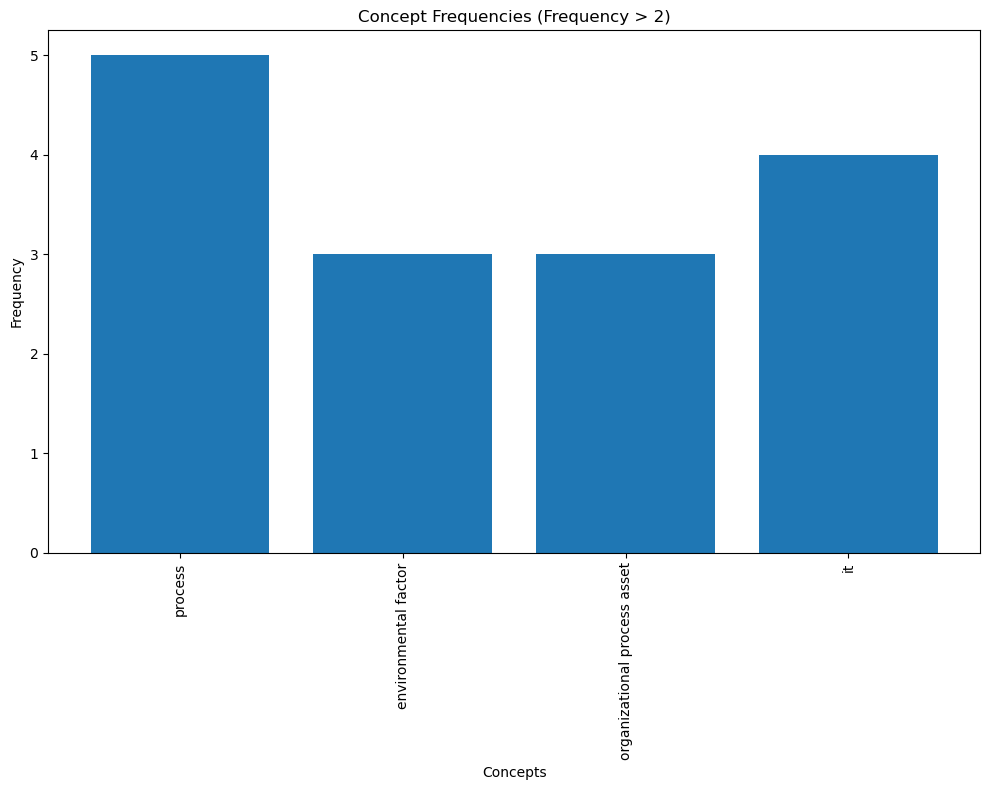

In [20]:
import matplotlib.pyplot as plt
from collections import Counter

# Your concatenated_values_reset Series
concept_freq = Counter(concatenated_values)

# Filter out concepts with frequency less than or equal to 2
filtered_concept_freq = {concept: freq for concept, freq in concept_freq.items() if freq > 2}

# Plot the filtered concept frequencies
plt.figure(figsize=(10, 8))
plt.bar(filtered_concept_freq.keys(), filtered_concept_freq.values())
plt.xlabel("Concepts")
plt.ylabel("Frequency")
plt.title("Concept Frequencies (Frequency > 2)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


#  TF-IDF(Vectorization) :

TF(t, d) = (Number of times term t appears in document d) / (Total number of terms in document d)

IDF(t, D) = log((Total number of documents in corpus D) / (Number of documents containing term t) + 1)

TF-IDF(t, d, D) = TF(t, d) * IDF(t, D)


mini function to remove any useless words:    (adding points)

In [21]:
def remove_stopwords_from_list2(text):
    
    pos_tags=pos_tagging(text)
    word_list=tokenize(text)
    # Define a list of POS tags for words to keep (e.g., nouns and adjectives)
    allowed_pos_tags = ['VBD',  # Verb, past tense
        'VBG',  # Verb, gerund or present participle
        'VBN',  # Verb, past participle
        'VBP',  # Verb, non-3rd person singular present
        'VBZ',  # Verb, 3rd person singular present
        'PRP','NN','VB',"MD", 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS']  # Nouns and adjectives
    
    # Filter out stopwords based on POS tags
    filtered_words = [word for word, pos_tag in zip(word_list, pos_tags) if pos_tag[1]
                      in allowed_pos_tags]
    
    return ' '.join(filtered_words)

In [22]:
# Assuming 'new' is your DataFrame and 'Description' is the column
documents = new['Description'].tolist()
# Apply the clean_text function to each document
documents = [remove_stopwords_from_list2(clean_text(doc)) for doc in documents]

In [23]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)

# Convert the TF-IDF matrix to a DataFrame
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Display the TF-IDF DataFrame
print(df_tfidf)

    0439salefornot  395ctionepifonotkey  397theydistrfornotrisks  402part  \
0              0.0                  0.0                      0.0      0.0   
1              0.0                  0.0                      0.0      0.0   
2              0.0                  0.0                      0.0      0.0   
3              0.0                  0.0                      0.0      0.0   
4              0.0                  0.0                      0.0      0.0   
..             ...                  ...                      ...      ...   
90             0.0                  0.0                      0.0      0.0   
91             0.0                  0.0                      0.0      0.0   
92             0.0                  0.0                      0.0      0.0   
93             0.0                  0.0                      0.0      0.0   
94             0.0                  0.0                      0.0      0.0   

    403oondoieriactorsafornot  405iodistributiofornot114  413icthrepgonc  \

#  Similarity:

In [24]:
def similarity(documents):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)
    
    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Create a DataFrame for the similarity matrix
    df = pd.DataFrame(similarity_matrix, index=[f"Doc_{i}" for i in range(1, len(documents) + 1)], columns=[f"Doc_{i}" for i in range(1, len(documents) + 1)])
    
    return df

In [25]:
# Call the similarity function
similarity_matrix = similarity(documents)

# Now, similarity_matrix is a DataFrame containing the similarity matrix
print(similarity_matrix)

           Doc_1     Doc_2     Doc_3     Doc_4     Doc_5     Doc_6     Doc_7  \
Doc_1   1.000000  0.095276  0.038068  0.062450  0.069322  0.051079  0.154826   
Doc_2   0.095276  1.000000  0.230081  0.236528  0.186740  0.043175  0.229764   
Doc_3   0.038068  0.230081  1.000000  0.094349  0.074364  0.018575  0.089988   
Doc_4   0.062450  0.236528  0.094349  1.000000  0.119344  0.020908  0.217208   
Doc_5   0.069322  0.186740  0.074364  0.119344  1.000000  0.031414  0.171785   
...          ...       ...       ...       ...       ...       ...       ...   
Doc_91  0.020143  0.060924  0.032345  0.027973  0.044327  0.078275  0.149150   
Doc_92  0.065671  0.091437  0.067596  0.075472  0.104307  0.024782  0.148811   
Doc_93  0.114431  0.062029  0.028079  0.051444  0.045132  0.015094  0.148204   
Doc_94  0.076717  0.137463  0.065621  0.078353  0.100016  0.061314  0.264452   
Doc_95  0.114363  0.086226  0.038988  0.043884  0.062737  0.068599  0.169169   

           Doc_8     Doc_9    Doc_10  .

#  LDA:

In [30]:
# Create a dictionary and a corpus
id2word = corpora.Dictionary([doc.split() for doc in documents])
corpus = [id2word.doc2bow(doc.split()) for doc in documents]

# Set the number of topics
num_topics = 30  # Adjust as needed

# LDA Model
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=num_topics,
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)

# Display topics
print(lda_model.print_topics())

[(2, '0.000*"project" + 0.000*"risk" + 0.000*"is" + 0.000*"risks" + 0.000*"be" + 0.000*"management" + 0.000*"are" + 0.000*"can" + 0.000*"managed" + 0.000*"levels"'), (12, '0.000*"be" + 0.000*"management" + 0.000*"section" + 0.000*"may" + 0.000*"risk" + 0.000*"plan" + 0.000*"are" + 0.000*"described" + 0.000*"checklist" + 0.000*"can"'), (0, '0.001*"project" + 0.001*"risk" + 0.001*"risks" + 0.001*"is" + 0.001*"are" + 0.001*"be" + 0.001*"management" + 0.000*"managed" + 0.000*"processes" + 0.000*"may"'), (14, '0.000*"project" + 0.000*"risk" + 0.000*"is" + 0.000*"risks" + 0.000*"be" + 0.000*"are" + 0.000*"management" + 0.000*"can" + 0.000*"managed" + 0.000*"may"'), (28, '0.001*"is" + 0.001*"opportunity" + 0.001*"risks" + 0.001*"may" + 0.001*"risk" + 0.001*"described" + 0.001*"project" + 0.001*"be" + 0.001*"it" + 0.001*"include"'), (23, '0.013*"process" + 0.013*"risk" + 0.013*"response" + 0.013*"agreedupon" + 0.013*"implementing" + 0.013*"plans" + 0.013*"responsesthe" + 0.000*"be" + 0.000*"ma

# Visualization of LDA

In [31]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

#  Identifying topics:

In [106]:
# Get the topics for each document
document_topics = [lda_model.get_document_topics(doc) for doc in corpus]

# Create a DataFrame to display topics for each document
df_topics = pd.DataFrame(index=range(1, len(documents) + 1))

# Iterate through the topics and populate the DataFrame
for i, topics in enumerate(document_topics, 1):
    topic_values = [topic[1] for topic in topics]
    df_topics[f'Doc_{i}'] = topic_values + [0] * (len(documents) - len(topic_values))

# Display the DataFrame with topics for each document
print(df_topics)

       Doc_1     Doc_2     Doc_3     Doc_4     Doc_5   Doc_6     Doc_7  \
1   0.909903  0.784200  0.092145  0.949245  0.954632  0.9069  0.997256   
2   0.000000  0.159642  0.860814  0.000000  0.000000  0.0000  0.000000   
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.0000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.0000  0.000000   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.0000  0.000000   
..       ...       ...       ...       ...       ...     ...       ...   
91  0.000000  0.000000  0.000000  0.000000  0.000000  0.0000  0.000000   
92  0.000000  0.000000  0.000000  0.000000  0.000000  0.0000  0.000000   
93  0.000000  0.000000  0.000000  0.000000  0.000000  0.0000  0.000000   
94  0.000000  0.000000  0.000000  0.000000  0.000000  0.0000  0.000000   
95  0.000000  0.000000  0.000000  0.000000  0.000000  0.0000  0.000000   

       Doc_8     Doc_9    Doc_10  ...    Doc_86    Doc_87    Doc_88   Doc_89  \
1   0.945279  0.943532  0.82037